# Traffic Sign Detection and Classification

We will start with a simple trained from scratch ResNet arquitecture using [fastai](https://github.com/fastai/fastai). This step will only use the largest area sign on the picture as there are pictures with more than one sign.

In [1]:
from xml.dom import minidom
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
train = []
test = []

with open("test.txt") as _file:
    for line in _file:
        train.append(line.replace('\n', ''))

with open("train.txt") as _file:
    for line in _file:
        test.append(line.replace('\n', ''))

def create_dataframe(data):
    signs = []
    for name in data:
        file = minidom.parse("annotations/" + name + ".xml")
        path = "images/" + file.getElementsByTagName('filename')[0].firstChild.data
        filename = file.getElementsByTagName('filename')[0].firstChild.data
        
        objects = file.getElementsByTagName('object')
        
        current_max = {"area": 0, "name": None}
        
        for obj in objects:
            xmin = obj.getElementsByTagName("xmin")[0].firstChild.data
            xmax = obj.getElementsByTagName("xmax")[0].firstChild.data
            ymin = obj.getElementsByTagName("ymin")[0].firstChild.data
            ymax = obj.getElementsByTagName("ymax")[0].firstChild.data
            
            name = obj.getElementsByTagName("name")[0].firstChild.data
            area = abs(int(xmax)-int(xmin))*abs(int(ymax)-int(ymin))
            if current_max["area"] < area:
                current_max = {"area": area, "name": name}

        signs.append([filename, current_max["name"], path])

    return pd.DataFrame(signs, columns=['filename', 'tag', 'path'])

df_train = create_dataframe(train)
df_test = create_dataframe(test)

## Train from scratch ResNet50

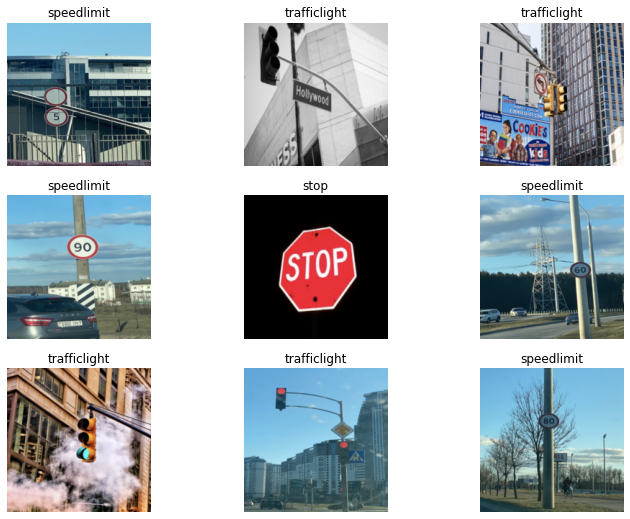

In [3]:
from fastai.vision.all import *

bs = 16
batch_tfms = aug_transforms(max_lighting=0.1, max_zoom=1.05, max_warp=0.)
item_tfms = [ Resize((200, 200), method='squish')]

datablock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=ColReader(0, pref='images/'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1),
                   item_tfms = item_tfms)

dls_train = datablock.dataloaders(df_train, bs=bs)
dls_test = dls_train.test_dl(df_test, with_labels=True, bs=bs)

dls_train.show_batch(max_n=9, figsize=(12,9))

In [4]:
learn = vision_learner(dls_train, resnet50, pretrained=False, metrics=[accuracy])

learn.fit(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.319745,1.065303,0.750000,00:03
1,1.874247,0.916411,0.769231,00:02
2,1.653751,0.778874,0.769231,00:02
3,1.506785,0.968078,0.788462,00:02
4,1.388652,0.825484,0.769231,00:02


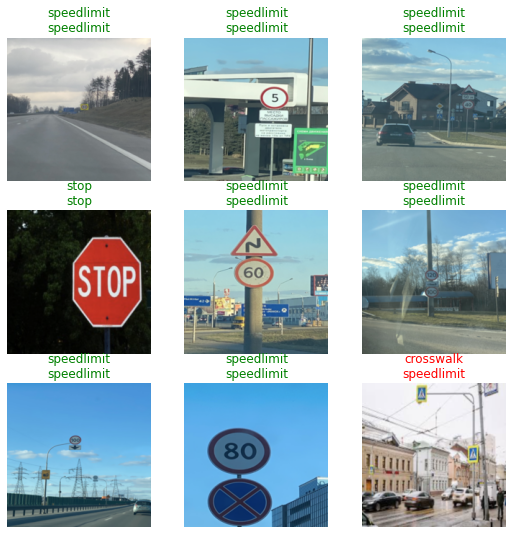

In [5]:
learn.show_results()

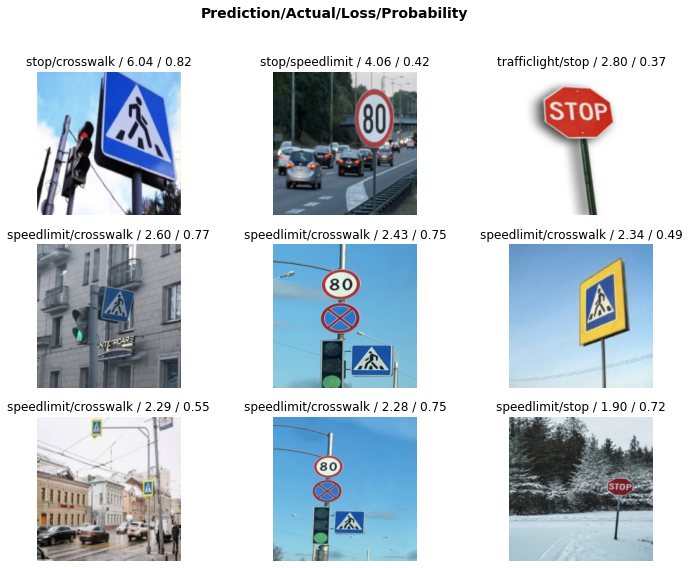

In [6]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(12,9));

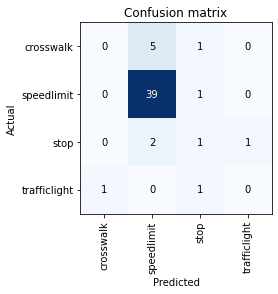

In [7]:
interp.plot_confusion_matrix()

In [8]:
doc(learn.validate)

In [9]:
loss, acc = learn.validate(dl=dls_test)

print(f'Loss: {loss}, Accuracy: {acc*100} %')

Loss: 0.9944992661476135, Accuracy: 72.59380221366882 %
